In [1]:
import scanpy as sc
import scvi
import muon as mu
import scib

In [2]:
mudata = mu.read("/home/icb/dominik.klein/git_repos/moscot_revisions/scMultiome_Mouse-Islets_NVF_E14-E16/scMultiome_Mouse-Islets_NVF_E14-E16_mdata_markedDoublets_mergedPeaks_normalized_rmDoublets.h5mu")

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [3]:
adata_gex = mudata["rna"]

In [4]:
sc.pp.highly_variable_genes(
    adata_gex,
    n_top_genes=2000,
    subset=True,
    layer="raw_counts",
    flavor="seurat_v3",
    batch_key="experiment_batch",
)

In [5]:
scvi.model.SCVI.setup_anndata(adata_gex, layer="raw_counts", batch_key="sample")

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [6]:
model = scvi.model.SCVI(adata_gex)

In [7]:
model.train()

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/dominik.klein/mambaforge/envs/scvi-tools/l ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/dominik.klein/mambaforge/envs/scvi-tools/l ...
  rank_zero_warn(
You are using a CUDA device ('NVID

Epoch 353/353: 100%|██████████| 353/353 [06:56<00:00,  1.09s/it, v_num=1, train_loss_step=989, train_loss_epoch=1.01e+3]    

`Trainer.fit` stopped: `max_epochs=353` reached.


Epoch 353/353: 100%|██████████| 353/353 [06:56<00:00,  1.18s/it, v_num=1, train_loss_step=989, train_loss_epoch=1.01e+3]


In [8]:
SCVI_LATENT_KEY = "X_scVI"
adata_gex.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
sc.pp.neighbors(adata_gex, use_rep=SCVI_LATENT_KEY)

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


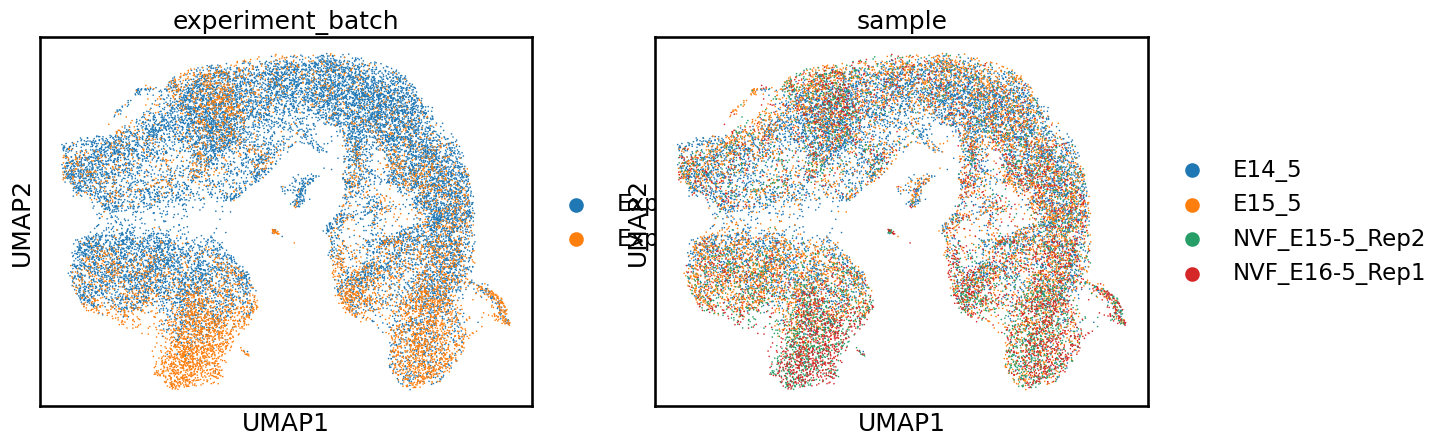

In [9]:
sc.tl.umap(adata_gex)
sc.pl.umap(adata_gex, color=["experiment_batch", "sample"])

In [10]:
adata_gex.layers["X_scVI_reconstruction"] = model.get_normalized_expression(adata_gex, transform_batch="E15_5")

In [11]:
adata_gex.X = adata_gex.layers["X_scVI_reconstruction"]

/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/scvi-tools/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


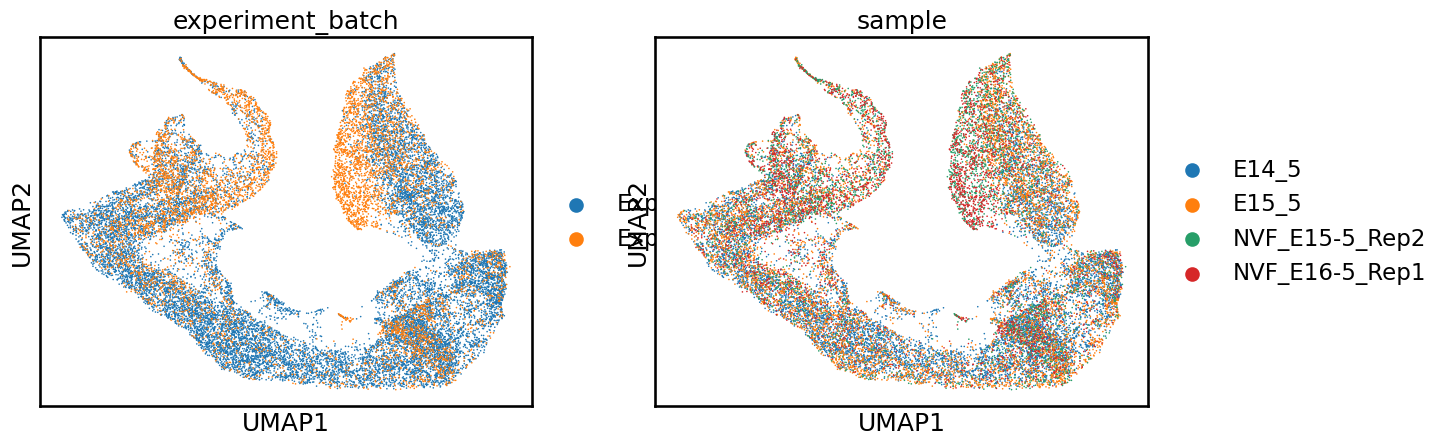

In [12]:
sc.pp.log1p(adata_gex)
sc.pp.pca(adata_gex)
sc.pp.neighbors(adata_gex)
sc.tl.umap(adata_gex)
sc.pl.umap(adata_gex, color=["experiment_batch", "sample"])

In [13]:
adata_gex.write("/lustre/groups/ml01/workspace/moscot_paper/pancreas_revision/adata_gex_scVI_highly_variable.h5ad")